In [10]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

In [12]:
# Define transformations for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


# Download the MNIST dataset
dataset = datasets.EuroSAT(root='./data', download=False, transform=transform)
# Split the dataset into train and test splits
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create data loaders for train and test splits
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

dataloaders = {'train': train_loader, 'val': test_loader}

print(f"Train dataset size: {len(train_loader)}")
print(f"Test dataset size: {len(test_loader)}")

dataset_sizes = {'train': len(train_loader.dataset), 'val': len(test_loader.dataset)}

Train dataset size: 675
Test dataset size: 169


In [13]:
# Load the pretrained ResNet18 model
model0 = models.resnet18(weights = models.ResNet18_Weights.IMAGENET1K_V1)

# Move the model to the appropriate device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model0.to(device)

# Extract features from the test data using the trained ResNet model
model0.eval()  # Set the model to evaluation mode
feature_extractor = torch.nn.Sequential(*list(model0.children())[:-1]) #get feature extractor

features = []
labels_list = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Pass data through the model up to the penultimate layer (before the fully connected layer)
        outputs = feature_extractor(inputs)
        outputs = torch.flatten(outputs, 1)  # Flatten the outputs
        features.append(outputs.cpu().numpy())
        labels_list.append(labels.cpu().numpy())

# Concatenate all features and labels
features = np.concatenate(features, axis=0)
labels_list = np.concatenate(labels_list, axis=0)

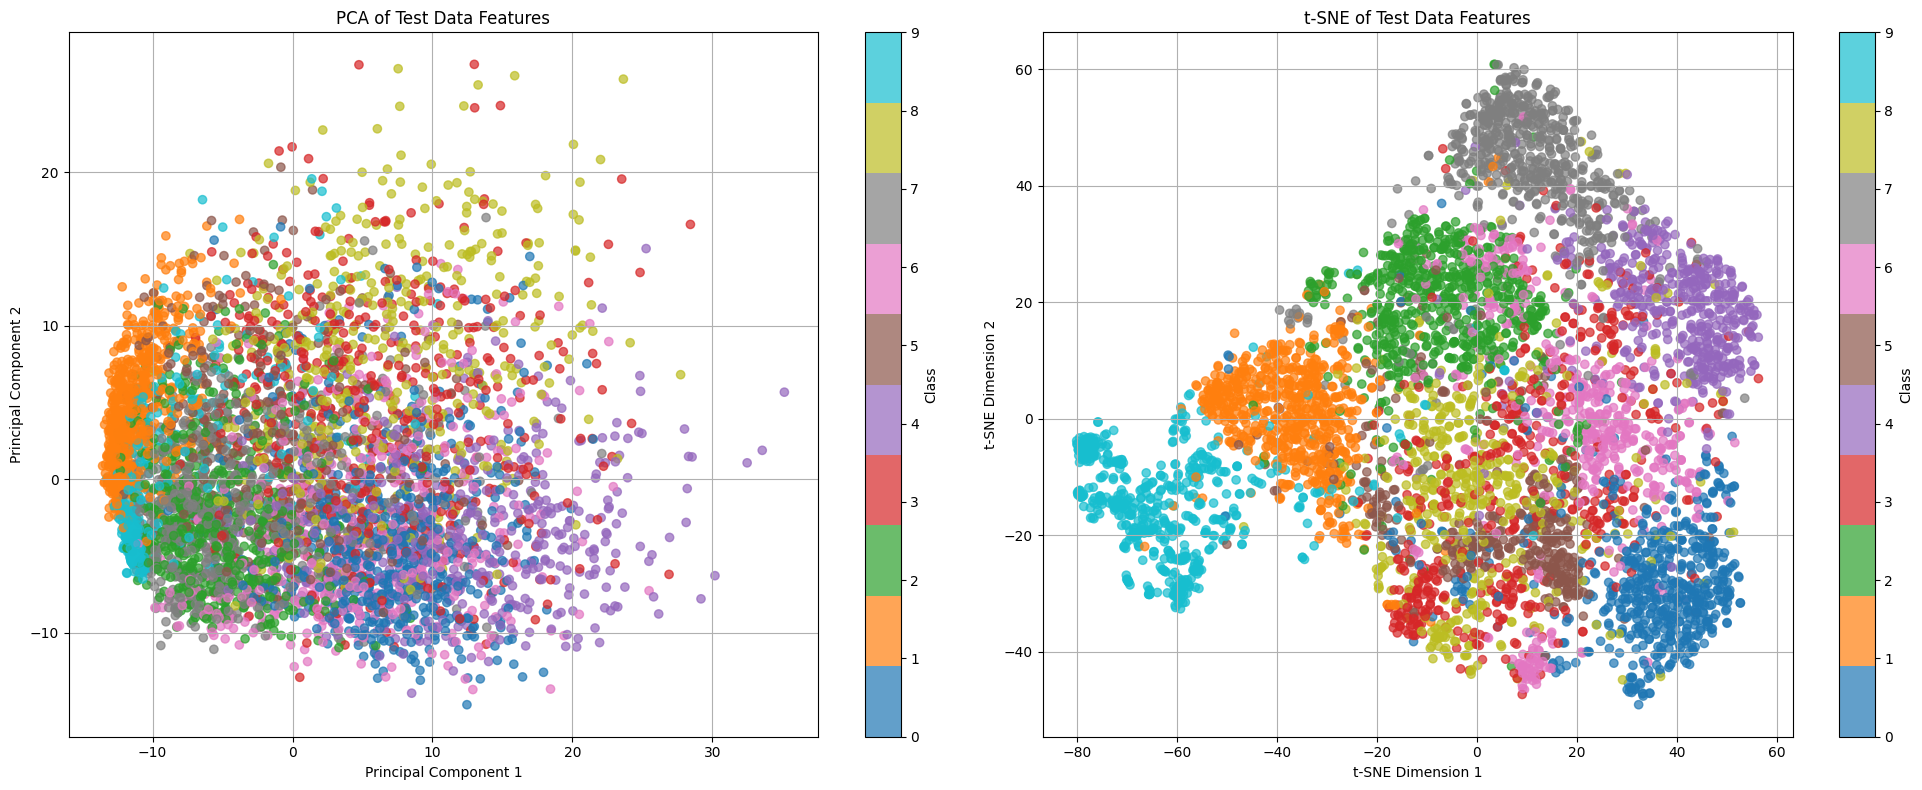

In [14]:


# Perform PCA on the extracted features
pca = PCA(n_components=2)
pca_features = pca.fit_transform(features)

# Perform t-SNE on the extracted features
tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(features)

# Combine PCA and t-SNE plots into one figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# PCA subplot
scatter_pca = axes[0].scatter(pca_features[:, 0], pca_features[:, 1], c=labels_list, cmap='tab10', alpha=0.7)
axes[0].set_title('PCA of Test Data Features')
axes[0].set_xlabel('Principal Component 1')
axes[0].set_ylabel('Principal Component 2')
axes[0].grid()
fig.colorbar(scatter_pca, ax=axes[0], label='Class')

# t-SNE subplot
scatter_tsne = axes[1].scatter(tsne_features[:, 0], tsne_features[:, 1], c=labels_list, cmap='tab10', alpha=0.7)
axes[1].set_title('t-SNE of Test Data Features')
axes[1].set_xlabel('t-SNE Dimension 1')
axes[1].set_ylabel('t-SNE Dimension 2')
axes[1].grid()
fig.colorbar(scatter_tsne, ax=axes[1], label='Class')

plt.tight_layout()



In [15]:
# Load the pretrained ResNet18 model
model = models.resnet18(weights = models.ResNet18_Weights.IMAGENET1K_V1)

# Modify the last fully connected layer to match the number of classes in CIFAR-10 (10 classes)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)


# Move the model to the appropriate device
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

# Training and validation loop
num_epochs = 20
train_loss_history = []
val_loss_history = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print("-" * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0

        # Iterate over data
        for inputs, labels in dataloaders[phase]:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Backward pass and optimize only in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / dataset_sizes[phase]

        if phase == 'train':
            train_loss_history.append(epoch_loss)
        else:
            val_loss_history.append(epoch_loss)

        print(f"{phase} Loss: {epoch_loss:.4f}")



Epoch 1/20
----------
train Loss: 0.9703
val Loss: 0.3745
Epoch 2/20
----------
train Loss: 0.3697
val Loss: 0.2423
Epoch 3/20
----------
train Loss: 0.2777
val Loss: 0.1958
Epoch 4/20
----------
train Loss: 0.2284
val Loss: 0.1730
Epoch 5/20
----------
train Loss: 0.2042
val Loss: 0.1588
Epoch 6/20
----------
train Loss: 0.1780
val Loss: 0.1515
Epoch 7/20
----------
train Loss: 0.1590
val Loss: 0.1403
Epoch 8/20
----------
train Loss: 0.1381
val Loss: 0.1345
Epoch 9/20
----------
train Loss: 0.1296
val Loss: 0.1299
Epoch 10/20
----------
train Loss: 0.1160
val Loss: 0.1273
Epoch 11/20
----------
train Loss: 0.1087
val Loss: 0.1310
Epoch 12/20
----------
train Loss: 0.0967
val Loss: 0.1193
Epoch 13/20
----------
train Loss: 0.0943
val Loss: 0.1229
Epoch 14/20
----------
train Loss: 0.0852
val Loss: 0.1231
Epoch 15/20
----------
train Loss: 0.0800
val Loss: 0.1205
Epoch 16/20
----------
train Loss: 0.0730
val Loss: 0.1175
Epoch 17/20
----------
train Loss: 0.0650
val Loss: 0.1143
Epoch 

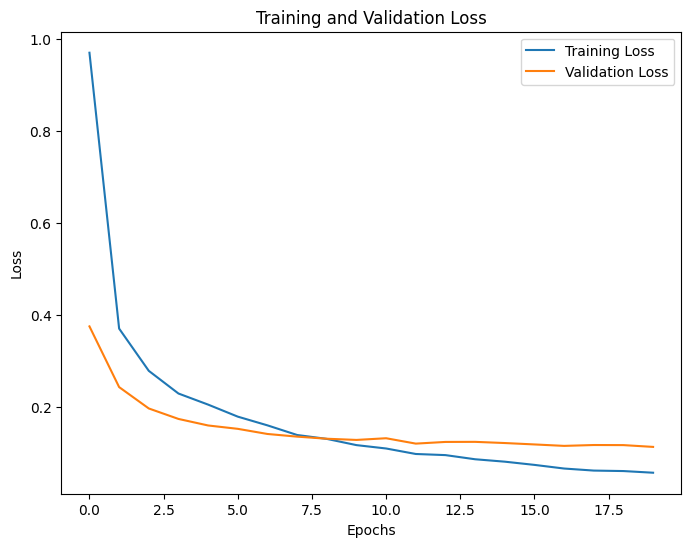

In [16]:
# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [17]:
# Extract features from the test data using the trained ResNet model
model.eval()  # Set the model to evaluation mode
feature_extractor = torch.nn.Sequential(*list(model.children())[:-1]) #get feature extractor

features = []
labels_list = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Pass data through the model up to the penultimate layer (before the fully connected layer)
        outputs = feature_extractor(inputs)
        outputs = torch.flatten(outputs, 1)  # Flatten the outputs
        features.append(outputs.cpu().numpy())
        labels_list.append(labels.cpu().numpy())

# Concatenate all features and labels
features = np.concatenate(features, axis=0)
labels_list = np.concatenate(labels_list, axis=0)

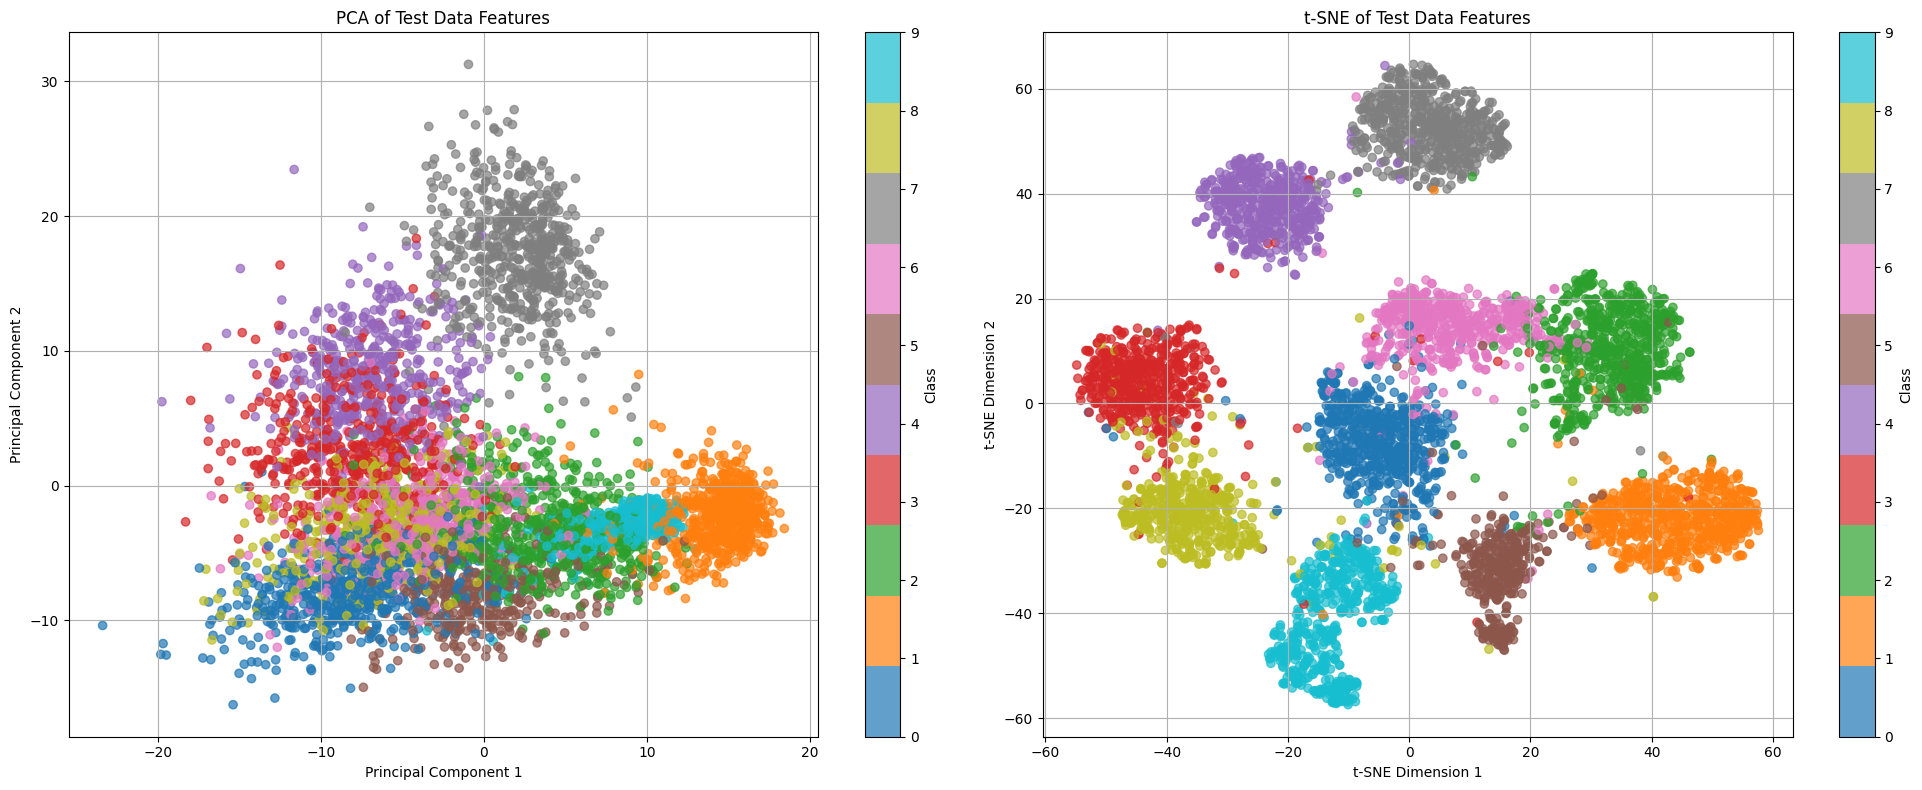

In [18]:


# Perform PCA on the extracted features
pca = PCA(n_components=2)
pca_features = pca.fit_transform(features)

# Perform t-SNE on the extracted features
tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(features)

# Combine PCA and t-SNE plots into one figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# PCA subplot
scatter_pca = axes[0].scatter(pca_features[:, 0], pca_features[:, 1], c=labels_list, cmap='tab10', alpha=0.7)
axes[0].set_title('PCA of Test Data Features')
axes[0].set_xlabel('Principal Component 1')
axes[0].set_ylabel('Principal Component 2')
axes[0].grid()
fig.colorbar(scatter_pca, ax=axes[0], label='Class')

# t-SNE subplot
scatter_tsne = axes[1].scatter(tsne_features[:, 0], tsne_features[:, 1], c=labels_list, cmap='tab10', alpha=0.7)
axes[1].set_title('t-SNE of Test Data Features')
axes[1].set_xlabel('t-SNE Dimension 1')
axes[1].set_ylabel('t-SNE Dimension 2')
axes[1].grid()
fig.colorbar(scatter_tsne, ax=axes[1], label='Class')

plt.tight_layout()

